In [1]:
from multi_omics_integration.func import *
from multi_omics_integration.classification_pipeline import *
from multi_omics_integration.processing import *
from multi_omics_integration.evaluation import *
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

In [2]:
datasets = {
            'rna': '../data/breast/RNASeq.csv',
            'mirna': '../data/breast/miRNASeq.csv',
            'methylation': '../data/breast/Methylation.csv',
}
        
labels = '../data/breast/Clinical.csv'

In [3]:
subtypes = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0)
    print(modality, data[modality].shape)

rna (430, 20155)
mirna (430, 823)
methylation (430, 20106)


# Preprocessing

## Removing low-variance + null features

In [4]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold(X, percentage=0.10):
    var_thr = VarianceThreshold(threshold=percentage) #Removing both constant and quasi-constant (less than 1% variance)

    X_new = var_thr.fit_transform(X)

    return X_new

In [5]:
new_data = {}
for modality in data:
    new_data[modality] = variance_threshold(data[modality], percentage=0.05)
    print(modality, new_data[modality].shape)

rna (430, 19291)
mirna (430, 583)
methylation (430, 754)


In [6]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in new_data:
    X[modality] = pd.DataFrame(new_data[modality])
    X[modality] = X[modality].dropna(axis=1)
    print(modality, X[modality].shape)

rna (430, 19291)
mirna (430, 583)
methylation (430, 705)


In [7]:
subtypes['PAM50'].value_counts()

LumA     229
LumB     100
Basal     71
Her2      30
Name: PAM50, dtype: int64

In [8]:
enc = LabelEncoder()
y = enc.fit_transform(subtypes['PAM50'])

In [9]:
enc.inverse_transform([0, 1, 2, 3])

array(['Basal', 'Her2', 'LumA', 'LumB'], dtype=object)

# Base Learners

In [11]:
from imblearn.pipeline import make_pipeline

In [12]:
estimators = [
    ("logistic", LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1)),
    ("random_forest", RandomForestClassifier(random_state=0, n_jobs=-1)),
    ("deep_nn", MLPClassifier(random_state=0)),
    ("svc", SVC(random_state=0, kernel='linear', max_iter=1000))
]

In [22]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.ensemble import BalancedRandomForestClassifier

estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    #("random_forest", RandomForestClassifier(random_state=0, n_jobs=-1)),
    ("balanced_random_forest", BalancedRandomForestClassifier(random_state=0, n_jobs=-1)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(random_state=0))),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

In [24]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})

 25%|██▌       | 1/4 [00:39<01:57, 39.13s/it]

logistic                  accuracy balanced_accuracy               f1   recall (Basal)  \
logistic  0.888 +/- 0.036   0.824 +/- 0.074  0.884 +/- 0.040  0.972 +/- 0.034   

            recall (Her2)    recall (LumA)    recall (LumB)  
logistic  0.600 +/- 0.226  0.952 +/- 0.017  0.770 +/- 0.121  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True`

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.847 +/- 0.037   0.865 +/- 0.042  0.852 +/- 0.034   

                         recall (Basal)    recall (Her2)    recall (LumA)  \
balanced_random_forest  0.958 +/- 0.034  0.867 +/- 0.125  0.825 +/- 0.066   

                          recall (LumB)  
balanced_random_forest  0.810 +/- 0.073  


 75%|███████▌  | 3/4 [01:07<00:20, 20.64s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (Basal)  \
deep_nn  0.884 +/- 0.044   0.858 +/- 0.073  0.884 +/- 0.044  0.972 +/- 0.034   

           recall (Her2)    recall (LumA)    recall (LumB)  
deep_nn  0.767 +/- 0.249  0.921 +/- 0.046  0.770 +/- 0.098  


100%|██████████| 4/4 [01:15<00:00, 18.83s/it]


svc             accuracy balanced_accuracy               f1   recall (Basal)  \
svc  0.912 +/- 0.024   0.889 +/- 0.032  0.910 +/- 0.026  0.972 +/- 0.034   

       recall (Her2)    recall (LumA)    recall (LumB)  
svc  0.833 +/- 0.105  0.952 +/- 0.017  0.800 +/- 0.110  


 25%|██▌       | 1/4 [00:00<00:02,  1.17it/s]

logistic                  accuracy balanced_accuracy               f1   recall (Basal)  \
logistic  0.816 +/- 0.017   0.747 +/- 0.061  0.811 +/- 0.024  0.930 +/- 0.062   

            recall (Her2)    recall (LumA)    recall (LumB)  
logistic  0.500 +/- 0.279  0.886 +/- 0.056  0.670 +/- 0.117  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'`

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.779 +/- 0.021   0.762 +/- 0.032  0.780 +/- 0.018   

                         recall (Basal)    recall (Her2)    recall (LumA)  \
balanced_random_forest  0.918 +/- 0.098  0.700 +/- 0.194  0.821 +/- 0.089   

                          recall (LumB)  
balanced_random_forest  0.610 +/- 0.153  


 75%|███████▌  | 3/4 [00:04<00:01,  1.85s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (Basal)  \
deep_nn  0.823 +/- 0.023   0.787 +/- 0.056  0.820 +/- 0.024  0.958 +/- 0.057   

           recall (Her2)    recall (LumA)    recall (LumB)  
deep_nn  0.667 +/- 0.211  0.882 +/- 0.052  0.640 +/- 0.102  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


svc             accuracy balanced_accuracy               f1   recall (Basal)  \
svc  0.816 +/- 0.031   0.775 +/- 0.077  0.811 +/- 0.039  0.958 +/- 0.057   

       recall (Her2)    recall (LumA)    recall (LumB)  
svc  0.633 +/- 0.287  0.878 +/- 0.053  0.630 +/- 0.103  


 25%|██▌       | 1/4 [00:01<00:05,  1.72s/it]

logistic                  accuracy balanced_accuracy               f1   recall (Basal)  \
logistic  0.833 +/- 0.050   0.791 +/- 0.057  0.830 +/- 0.053  0.958 +/- 0.034   

            recall (Her2)    recall (LumA)    recall (LumB)  
logistic  0.633 +/- 0.067  0.882 +/- 0.045  0.690 +/- 0.156  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'`

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.763 +/- 0.062   0.807 +/- 0.069  0.769 +/- 0.061   

                         recall (Basal)    recall (Her2)    recall (LumA)  \
balanced_random_forest  0.958 +/- 0.034  0.867 +/- 0.194  0.725 +/- 0.070   

                          recall (LumB)  
balanced_random_forest  0.680 +/- 0.125  


 75%|███████▌  | 3/4 [00:06<00:02,  2.18s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (Basal)  \
deep_nn  0.823 +/- 0.051   0.816 +/- 0.073  0.818 +/- 0.055  0.958 +/- 0.034   

           recall (Her2)    recall (LumA)    recall (LumB)  
deep_nn  0.833 +/- 0.149  0.882 +/- 0.061  0.590 +/- 0.150  


100%|██████████| 4/4 [00:06<00:00,  1.64s/it]

svc             accuracy balanced_accuracy               f1   recall (Basal)  \
svc  0.830 +/- 0.040   0.808 +/- 0.053  0.830 +/- 0.040  0.972 +/- 0.034   

       recall (Her2)    recall (LumA)    recall (LumB)  
svc  0.700 +/- 0.125  0.860 +/- 0.049  0.700 +/- 0.084  


In [15]:
display(base_metrics_df['rna']), display(base_metrics_df['mirna']), display(base_metrics_df['methylation'])

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.888 +/- 0.036,0.824 +/- 0.074,0.884 +/- 0.040,0.972 +/- 0.034,0.600 +/- 0.226,0.952 +/- 0.017,0.770 +/- 0.121
random_forest,0.870 +/- 0.023,0.753 +/- 0.033,0.858 +/- 0.024,0.972 +/- 0.034,0.333 +/- 0.105,0.965 +/- 0.030,0.740 +/- 0.080
deep_nn,0.884 +/- 0.044,0.858 +/- 0.073,0.884 +/- 0.044,0.972 +/- 0.034,0.767 +/- 0.249,0.921 +/- 0.046,0.770 +/- 0.098
svc,0.912 +/- 0.024,0.889 +/- 0.032,0.910 +/- 0.026,0.972 +/- 0.034,0.833 +/- 0.105,0.952 +/- 0.017,0.800 +/- 0.110


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.816 +/- 0.017,0.747 +/- 0.061,0.811 +/- 0.024,0.930 +/- 0.062,0.500 +/- 0.279,0.886 +/- 0.056,0.670 +/- 0.117
random_forest,0.767 +/- 0.019,0.591 +/- 0.031,0.730 +/- 0.026,0.930 +/- 0.062,0.000 +/- 0.000,0.934 +/- 0.028,0.500 +/- 0.122
deep_nn,0.823 +/- 0.023,0.787 +/- 0.056,0.820 +/- 0.024,0.958 +/- 0.057,0.667 +/- 0.211,0.882 +/- 0.052,0.640 +/- 0.102
svc,0.816 +/- 0.031,0.775 +/- 0.077,0.811 +/- 0.039,0.958 +/- 0.057,0.633 +/- 0.287,0.878 +/- 0.053,0.630 +/- 0.103


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.833 +/- 0.050,0.791 +/- 0.057,0.830 +/- 0.053,0.958 +/- 0.034,0.633 +/- 0.067,0.882 +/- 0.045,0.690 +/- 0.156
random_forest,0.784 +/- 0.035,0.711 +/- 0.061,0.765 +/- 0.041,0.972 +/- 0.034,0.533 +/- 0.221,0.917 +/- 0.032,0.420 +/- 0.093
deep_nn,0.823 +/- 0.051,0.816 +/- 0.073,0.818 +/- 0.055,0.958 +/- 0.034,0.833 +/- 0.149,0.882 +/- 0.061,0.590 +/- 0.150
svc,0.830 +/- 0.040,0.808 +/- 0.053,0.830 +/- 0.040,0.972 +/- 0.034,0.700 +/- 0.125,0.860 +/- 0.049,0.700 +/- 0.084


(None, None, None)

In [25]:
display(base_metrics_df['rna']), display(base_metrics_df['mirna']), display(base_metrics_df['methylation'])

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.888 +/- 0.036,0.824 +/- 0.074,0.884 +/- 0.040,0.972 +/- 0.034,0.600 +/- 0.226,0.952 +/- 0.017,0.770 +/- 0.121
balanced_random_forest,0.847 +/- 0.037,0.865 +/- 0.042,0.852 +/- 0.034,0.958 +/- 0.034,0.867 +/- 0.125,0.825 +/- 0.066,0.810 +/- 0.073
deep_nn,0.884 +/- 0.044,0.858 +/- 0.073,0.884 +/- 0.044,0.972 +/- 0.034,0.767 +/- 0.249,0.921 +/- 0.046,0.770 +/- 0.098
svc,0.912 +/- 0.024,0.889 +/- 0.032,0.910 +/- 0.026,0.972 +/- 0.034,0.833 +/- 0.105,0.952 +/- 0.017,0.800 +/- 0.110


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.816 +/- 0.017,0.747 +/- 0.061,0.811 +/- 0.024,0.930 +/- 0.062,0.500 +/- 0.279,0.886 +/- 0.056,0.670 +/- 0.117
balanced_random_forest,0.779 +/- 0.021,0.762 +/- 0.032,0.780 +/- 0.018,0.918 +/- 0.098,0.700 +/- 0.194,0.821 +/- 0.089,0.610 +/- 0.153
deep_nn,0.823 +/- 0.023,0.787 +/- 0.056,0.820 +/- 0.024,0.958 +/- 0.057,0.667 +/- 0.211,0.882 +/- 0.052,0.640 +/- 0.102
svc,0.816 +/- 0.031,0.775 +/- 0.077,0.811 +/- 0.039,0.958 +/- 0.057,0.633 +/- 0.287,0.878 +/- 0.053,0.630 +/- 0.103


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.833 +/- 0.050,0.791 +/- 0.057,0.830 +/- 0.053,0.958 +/- 0.034,0.633 +/- 0.067,0.882 +/- 0.045,0.690 +/- 0.156
balanced_random_forest,0.763 +/- 0.062,0.807 +/- 0.069,0.769 +/- 0.061,0.958 +/- 0.034,0.867 +/- 0.194,0.725 +/- 0.070,0.680 +/- 0.125
deep_nn,0.823 +/- 0.051,0.816 +/- 0.073,0.818 +/- 0.055,0.958 +/- 0.034,0.833 +/- 0.149,0.882 +/- 0.061,0.590 +/- 0.150
svc,0.830 +/- 0.040,0.808 +/- 0.053,0.830 +/- 0.040,0.972 +/- 0.034,0.700 +/- 0.125,0.860 +/- 0.049,0.700 +/- 0.084


(None, None, None)

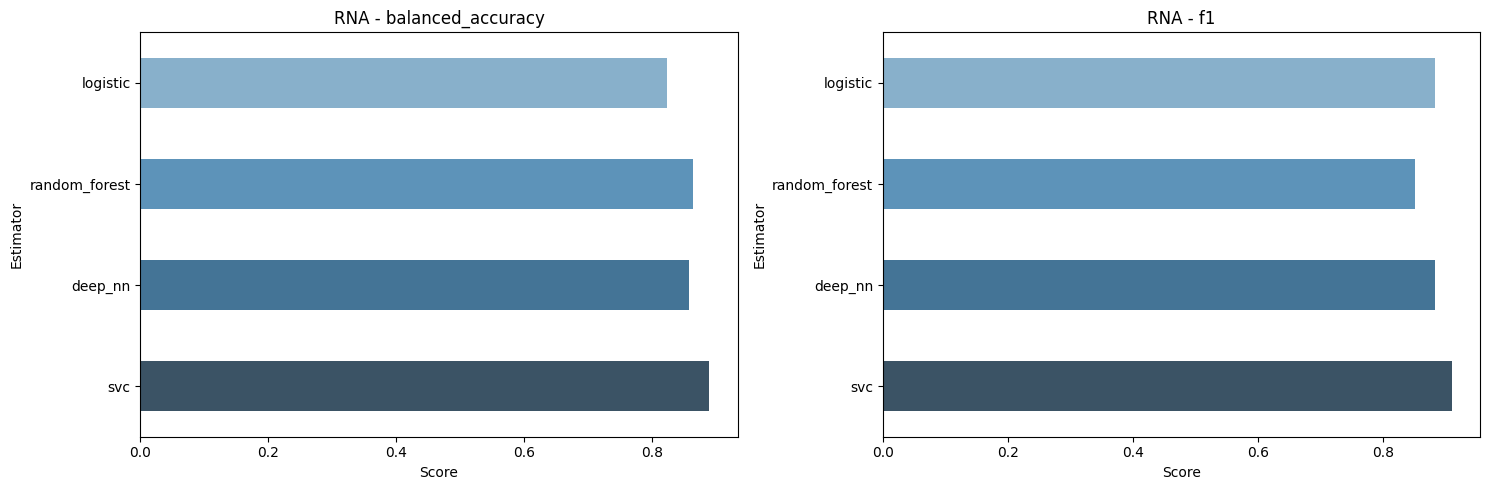

In [21]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

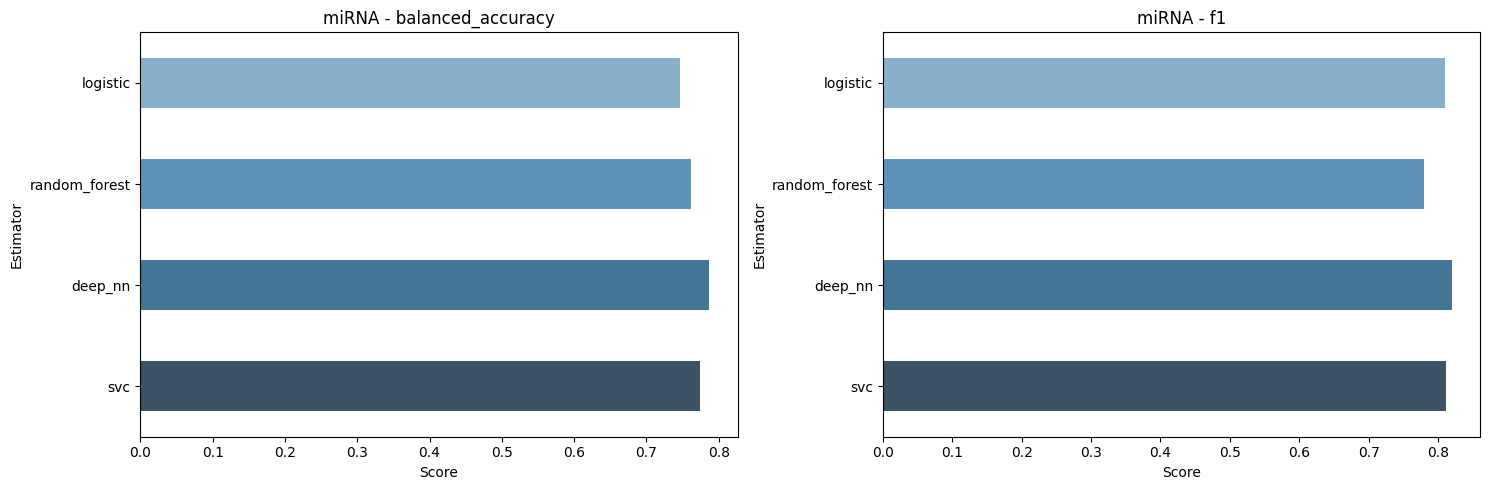

In [22]:
plot_bar_scores(estimator_names, base_scores['mirna'], 'miRNA', metrics=['balanced_accuracy', 'f1'])

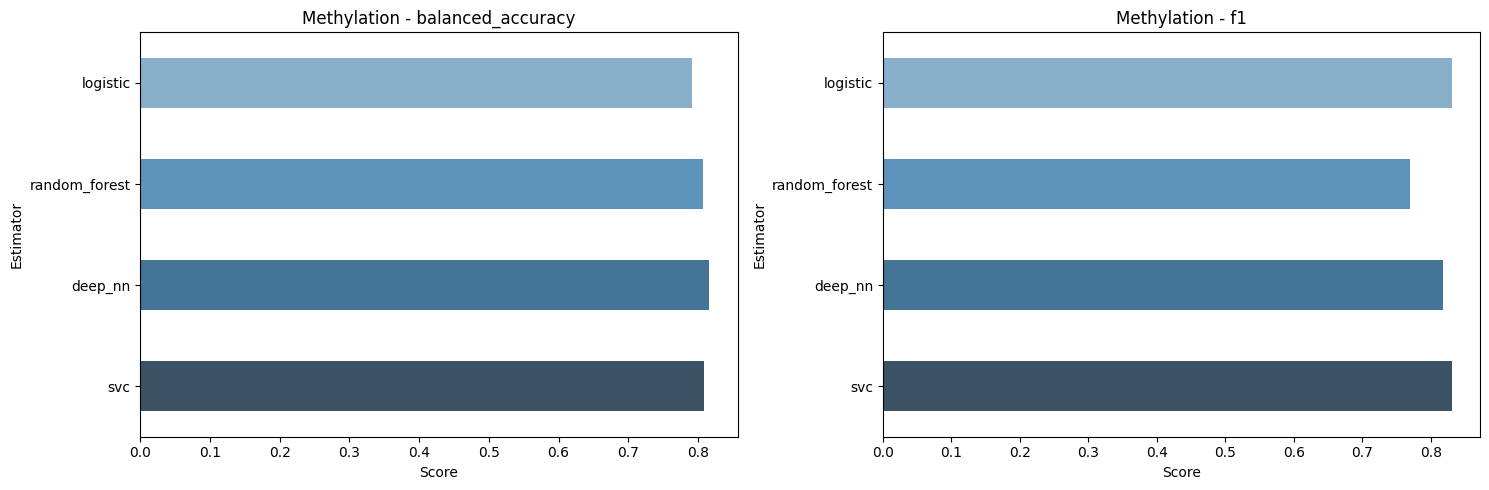

In [23]:
plot_bar_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

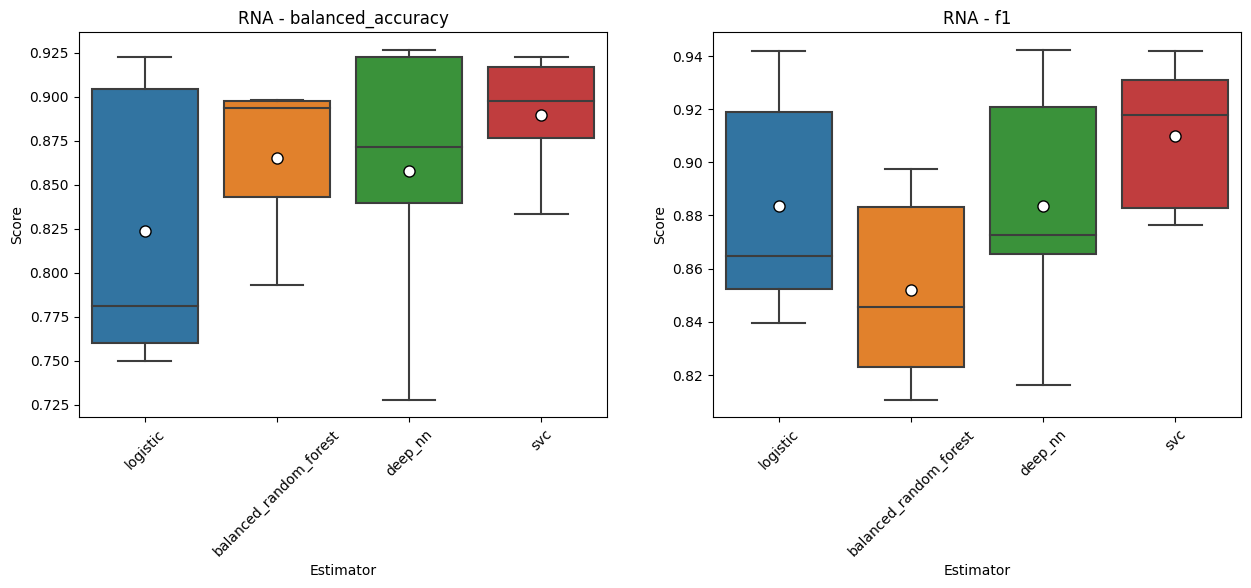

In [28]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

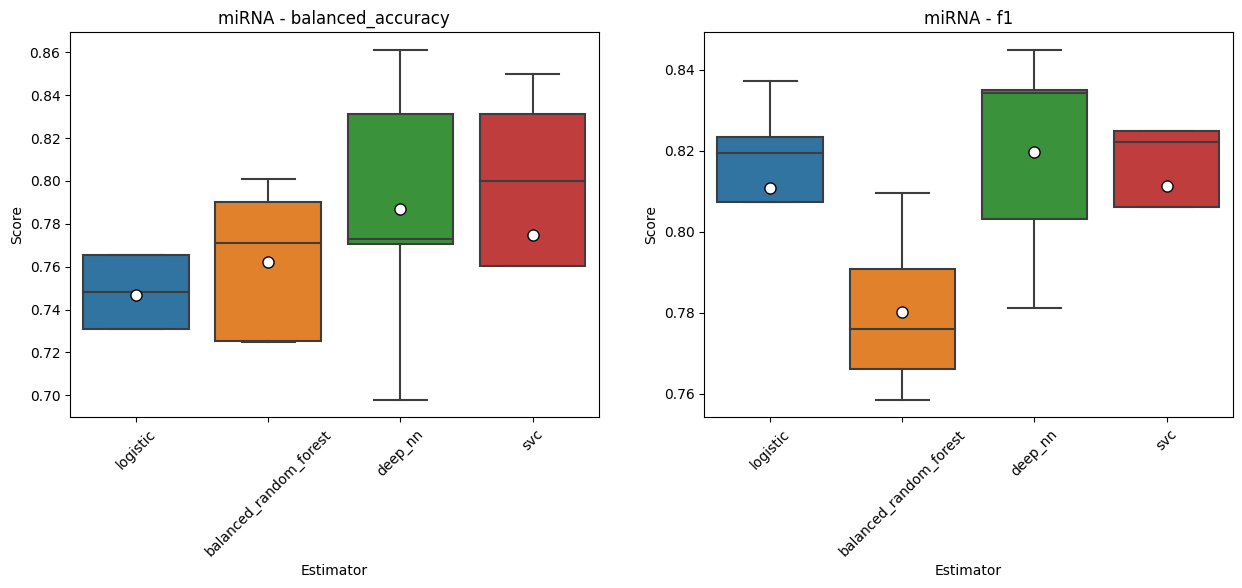

In [29]:
plot_box_scores(estimator_names, base_scores['mirna'], 'miRNA', metrics=['balanced_accuracy', 'f1'])

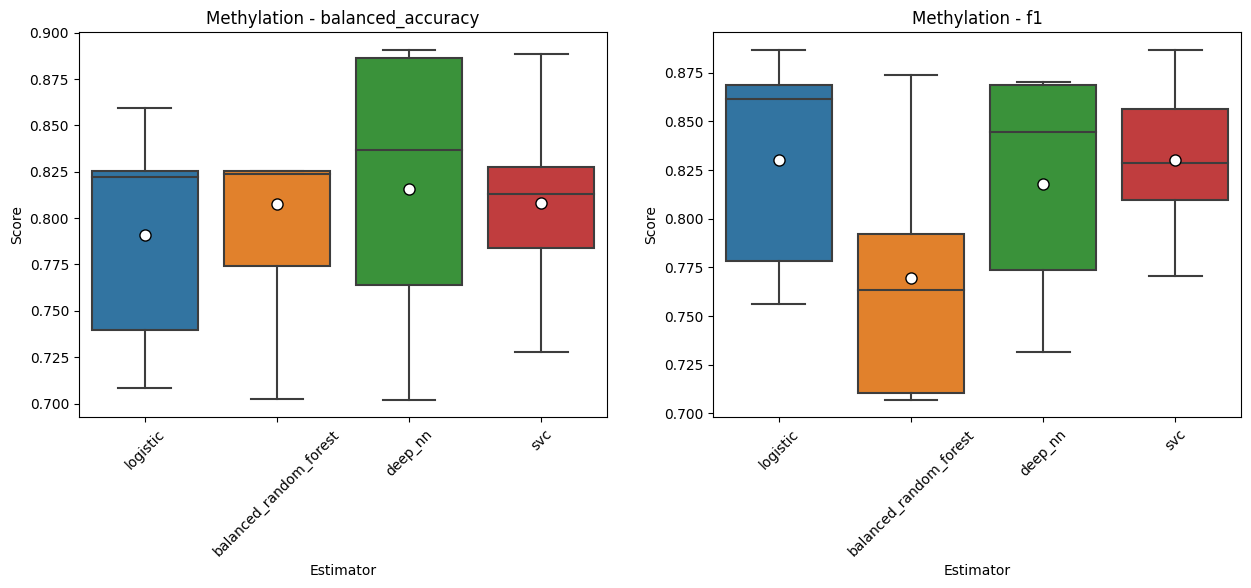

In [30]:
plot_box_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

# Modality Ensembles

In [16]:
from multi_omics_integration.classification_pipeline import Debugger

class ModalityPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, estimator_list=None, feature_select=None, final_estimator=LogisticRegression(random_state=0, n_jobs=-1), cv=5, n_jobs=-1, stack_method='auto'):
        self.cv = cv
        self.estimator_list = estimator_list
        self.feature_select = feature_select
        self.final_estimator = final_estimator
        self.n_jobs=n_jobs
        self.stack_method = stack_method
        
    def _get_model(self):
        self.cv_ = StratifiedKFold(n_splits=self.cv, random_state=0, shuffle=True)
        self.final_estimator_ = Pipeline([('imputer', SimpleImputer(strategy='median')), ('final', self.final_estimator)])
        
        stacking = StackingClassifier(estimators=self.estimator_list, final_estimator=self.final_estimator_, cv=self.cv_, stack_method=self.stack_method, n_jobs=self.n_jobs)
        
        if self.feature_select != None:
            model = Pipeline([('feature_selection', self.feature_select), ('clf', stacking)])
        else:
            model = stacking
        
        return model
    
    def fit(self, X, y):
        self.model_ = self._get_model()
        self.model_.fit(X, y)
        self.classes_ = self.model_.classes_
        self.coef_ = self.model_.final_estimator_.named_steps['final'].coef_
        
        return self
    
    def predict(self, X):
        return self.model_.predict(X)
    
    def predict_proba(self, X):
        return self.model_.predict_proba(X)

In [31]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=3)

In [32]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})
    modality_metrics = pd.concat([modality_metrics, df])
    print(df)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed 

            accuracy balanced_accuracy               f1   recall (Basal)  \
rna  0.907 +/- 0.030   0.886 +/- 0.053  0.905 +/- 0.032  0.972 +/- 0.034   

       recall (Her2)    recall (LumA)    recall (LumB)  
rna  0.833 +/- 0.183  0.947 +/- 0.023  0.790 +/- 0.111  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set t

              accuracy balanced_accuracy               f1   recall (Basal)  \
mirna  0.816 +/- 0.027   0.774 +/- 0.046  0.808 +/- 0.032  0.958 +/- 0.057   

         recall (Her2)    recall (LumA)    recall (LumB)  
mirna  0.667 +/- 0.211  0.900 +/- 0.059  0.570 +/- 0.150  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True`

                    accuracy balanced_accuracy               f1  \
methylation  0.835 +/- 0.055   0.809 +/- 0.065  0.832 +/- 0.060   

              recall (Basal)    recall (Her2)    recall (LumA)  \
methylation  0.958 +/- 0.034  0.733 +/- 0.082  0.886 +/- 0.038   

               recall (LumB)  
methylation  0.660 +/- 0.169  


In [33]:
# Balanced random forest and standard scaler with deep neural network
modality_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
rna,0.907 +/- 0.030,0.886 +/- 0.053,0.905 +/- 0.032,0.972 +/- 0.034,0.833 +/- 0.183,0.947 +/- 0.023,0.790 +/- 0.111
mirna,0.816 +/- 0.027,0.774 +/- 0.046,0.808 +/- 0.032,0.958 +/- 0.057,0.667 +/- 0.211,0.900 +/- 0.059,0.570 +/- 0.150
methylation,0.835 +/- 0.055,0.809 +/- 0.065,0.832 +/- 0.060,0.958 +/- 0.034,0.733 +/- 0.082,0.886 +/- 0.038,0.660 +/- 0.169


In [34]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc",
    "stacking"
]

all_scores = base_scores
all_scores['rna'].append(scores['rna'])
all_scores['mirna'].append(scores['mirna'])
all_scores['methylation'].append(scores['methylation'])

In [35]:
all_metrics = {}

# Joining metrics together for visualization
for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [36]:
# Balanced random forest and standard scaler with deep neural network
display(all_metrics['rna'], all_metrics['mirna'], all_metrics['methylation'])

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.888 +/- 0.036,0.824 +/- 0.074,0.884 +/- 0.040,0.972 +/- 0.034,0.600 +/- 0.226,0.952 +/- 0.017,0.770 +/- 0.121
balanced_random_forest,0.847 +/- 0.037,0.865 +/- 0.042,0.852 +/- 0.034,0.958 +/- 0.034,0.867 +/- 0.125,0.825 +/- 0.066,0.810 +/- 0.073
deep_nn,0.884 +/- 0.044,0.858 +/- 0.073,0.884 +/- 0.044,0.972 +/- 0.034,0.767 +/- 0.249,0.921 +/- 0.046,0.770 +/- 0.098
svc,0.912 +/- 0.024,0.889 +/- 0.032,0.910 +/- 0.026,0.972 +/- 0.034,0.833 +/- 0.105,0.952 +/- 0.017,0.800 +/- 0.110
rna,0.907 +/- 0.030,0.886 +/- 0.053,0.905 +/- 0.032,0.972 +/- 0.034,0.833 +/- 0.183,0.947 +/- 0.023,0.790 +/- 0.111


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.816 +/- 0.017,0.747 +/- 0.061,0.811 +/- 0.024,0.930 +/- 0.062,0.500 +/- 0.279,0.886 +/- 0.056,0.670 +/- 0.117
balanced_random_forest,0.779 +/- 0.021,0.762 +/- 0.032,0.780 +/- 0.018,0.918 +/- 0.098,0.700 +/- 0.194,0.821 +/- 0.089,0.610 +/- 0.153
deep_nn,0.823 +/- 0.023,0.787 +/- 0.056,0.820 +/- 0.024,0.958 +/- 0.057,0.667 +/- 0.211,0.882 +/- 0.052,0.640 +/- 0.102
svc,0.816 +/- 0.031,0.775 +/- 0.077,0.811 +/- 0.039,0.958 +/- 0.057,0.633 +/- 0.287,0.878 +/- 0.053,0.630 +/- 0.103
mirna,0.816 +/- 0.027,0.774 +/- 0.046,0.808 +/- 0.032,0.958 +/- 0.057,0.667 +/- 0.211,0.900 +/- 0.059,0.570 +/- 0.150


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.833 +/- 0.050,0.791 +/- 0.057,0.830 +/- 0.053,0.958 +/- 0.034,0.633 +/- 0.067,0.882 +/- 0.045,0.690 +/- 0.156
balanced_random_forest,0.763 +/- 0.062,0.807 +/- 0.069,0.769 +/- 0.061,0.958 +/- 0.034,0.867 +/- 0.194,0.725 +/- 0.070,0.680 +/- 0.125
deep_nn,0.823 +/- 0.051,0.816 +/- 0.073,0.818 +/- 0.055,0.958 +/- 0.034,0.833 +/- 0.149,0.882 +/- 0.061,0.590 +/- 0.150
svc,0.830 +/- 0.040,0.808 +/- 0.053,0.830 +/- 0.040,0.972 +/- 0.034,0.700 +/- 0.125,0.860 +/- 0.049,0.700 +/- 0.084
methylation,0.835 +/- 0.055,0.809 +/- 0.065,0.832 +/- 0.060,0.958 +/- 0.034,0.733 +/- 0.082,0.886 +/- 0.038,0.660 +/- 0.169


In [100]:
# With random forest and no standard scaler with deep neural network
display(all_metrics['rna'], all_metrics['mirna'], all_metrics['methylation'])

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.888 +/- 0.036,0.824 +/- 0.074,0.884 +/- 0.040,0.972 +/- 0.034,0.600 +/- 0.226,0.952 +/- 0.017,0.770 +/- 0.121
random_forest,0.870 +/- 0.023,0.753 +/- 0.033,0.858 +/- 0.024,0.972 +/- 0.034,0.333 +/- 0.105,0.965 +/- 0.030,0.740 +/- 0.080
deep_nn,0.584 +/- 0.098,0.348 +/- 0.196,0.455 +/- 0.165,0.187 +/- 0.373,0.067 +/- 0.133,0.938 +/- 0.124,0.200 +/- 0.400
svc,0.912 +/- 0.024,0.889 +/- 0.032,0.910 +/- 0.026,0.972 +/- 0.034,0.833 +/- 0.105,0.952 +/- 0.017,0.800 +/- 0.110
rna,0.914 +/- 0.032,0.890 +/- 0.053,0.911 +/- 0.034,0.972 +/- 0.034,0.833 +/- 0.183,0.956 +/- 0.014,0.800 +/- 0.122


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.816 +/- 0.017,0.747 +/- 0.061,0.811 +/- 0.024,0.930 +/- 0.062,0.500 +/- 0.279,0.886 +/- 0.056,0.670 +/- 0.117
random_forest,0.767 +/- 0.019,0.591 +/- 0.031,0.730 +/- 0.026,0.930 +/- 0.062,0.000 +/- 0.000,0.934 +/- 0.028,0.500 +/- 0.122
deep_nn,0.809 +/- 0.022,0.755 +/- 0.056,0.805 +/- 0.023,0.945 +/- 0.050,0.567 +/- 0.226,0.878 +/- 0.068,0.630 +/- 0.093
svc,0.816 +/- 0.031,0.775 +/- 0.077,0.811 +/- 0.039,0.958 +/- 0.057,0.633 +/- 0.287,0.878 +/- 0.053,0.630 +/- 0.103
mirna,0.830 +/- 0.019,0.793 +/- 0.041,0.826 +/- 0.019,0.958 +/- 0.057,0.700 +/- 0.194,0.904 +/- 0.051,0.610 +/- 0.086


,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
logistic,0.833 +/- 0.050,0.791 +/- 0.057,0.830 +/- 0.053,0.958 +/- 0.034,0.633 +/- 0.067,0.882 +/- 0.045,0.690 +/- 0.156
random_forest,0.784 +/- 0.035,0.711 +/- 0.061,0.765 +/- 0.041,0.972 +/- 0.034,0.533 +/- 0.221,0.917 +/- 0.032,0.420 +/- 0.093
deep_nn,0.835 +/- 0.042,0.805 +/- 0.055,0.830 +/- 0.046,0.958 +/- 0.034,0.733 +/- 0.133,0.900 +/- 0.029,0.630 +/- 0.144
svc,0.830 +/- 0.040,0.808 +/- 0.053,0.830 +/- 0.040,0.972 +/- 0.034,0.700 +/- 0.125,0.860 +/- 0.049,0.700 +/- 0.084
methylation,0.833 +/- 0.050,0.799 +/- 0.051,0.827 +/- 0.056,0.972 +/- 0.034,0.700 +/- 0.067,0.895 +/- 0.037,0.630 +/- 0.181


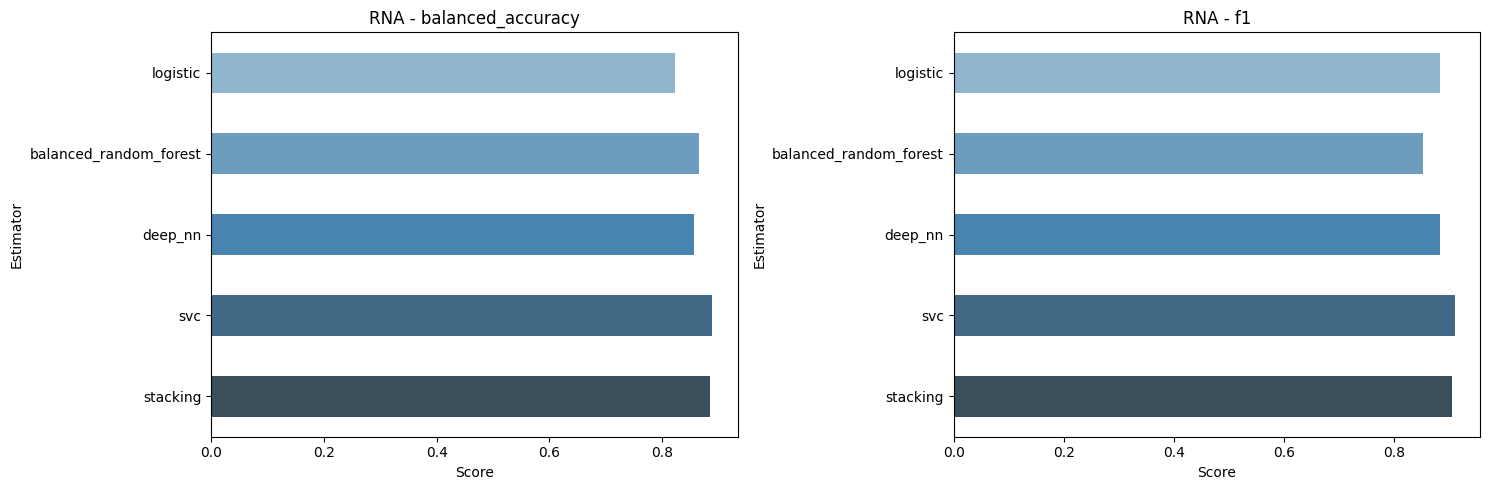

In [37]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

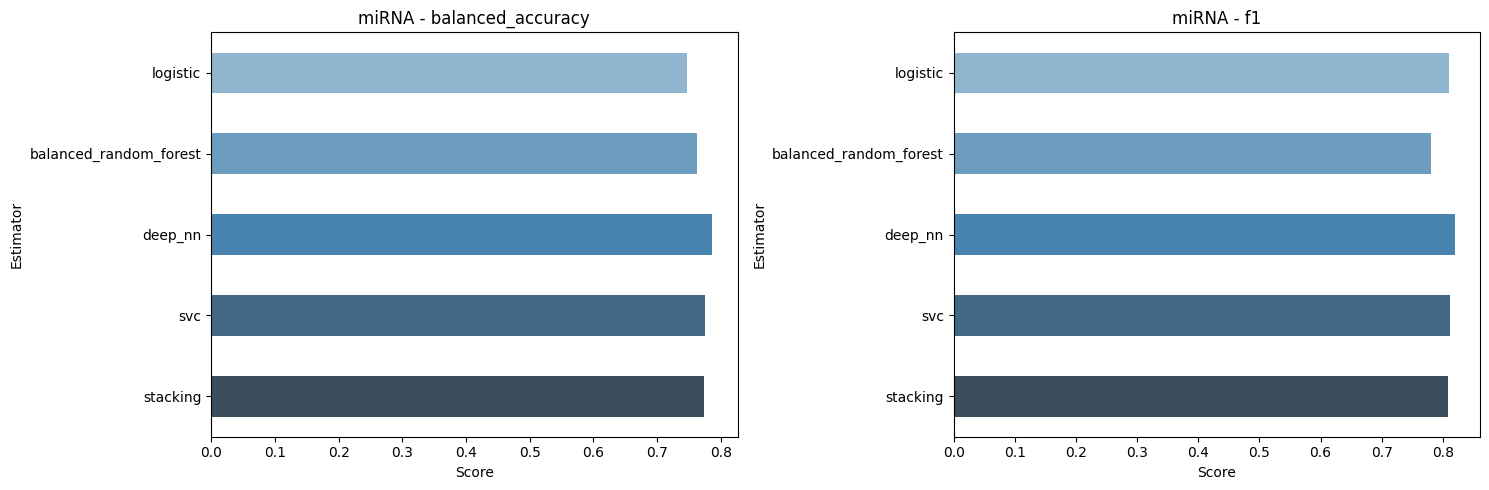

In [39]:
plot_bar_scores(estimator_names, base_scores['mirna'], 'miRNA', metrics=['balanced_accuracy', 'f1'])

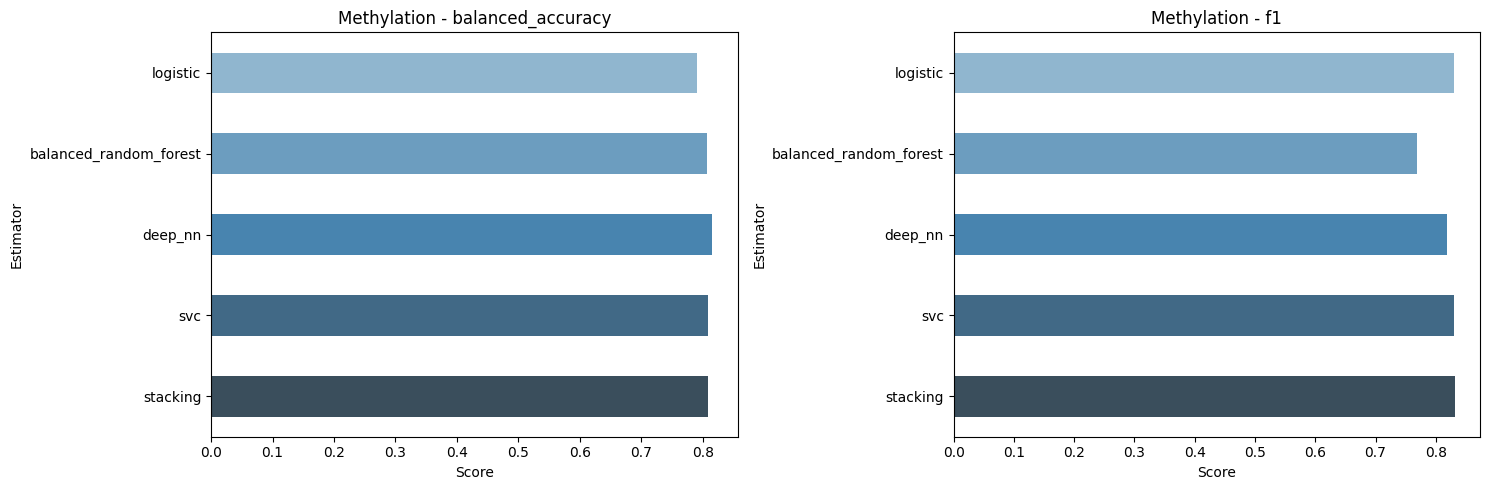

In [40]:
plot_bar_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

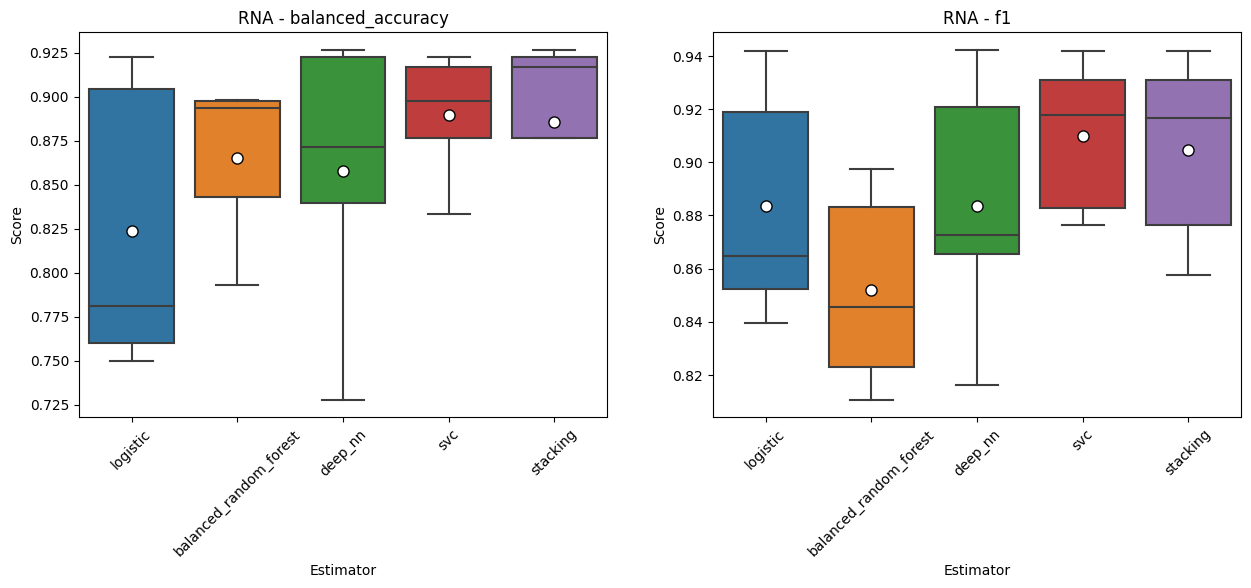

In [41]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

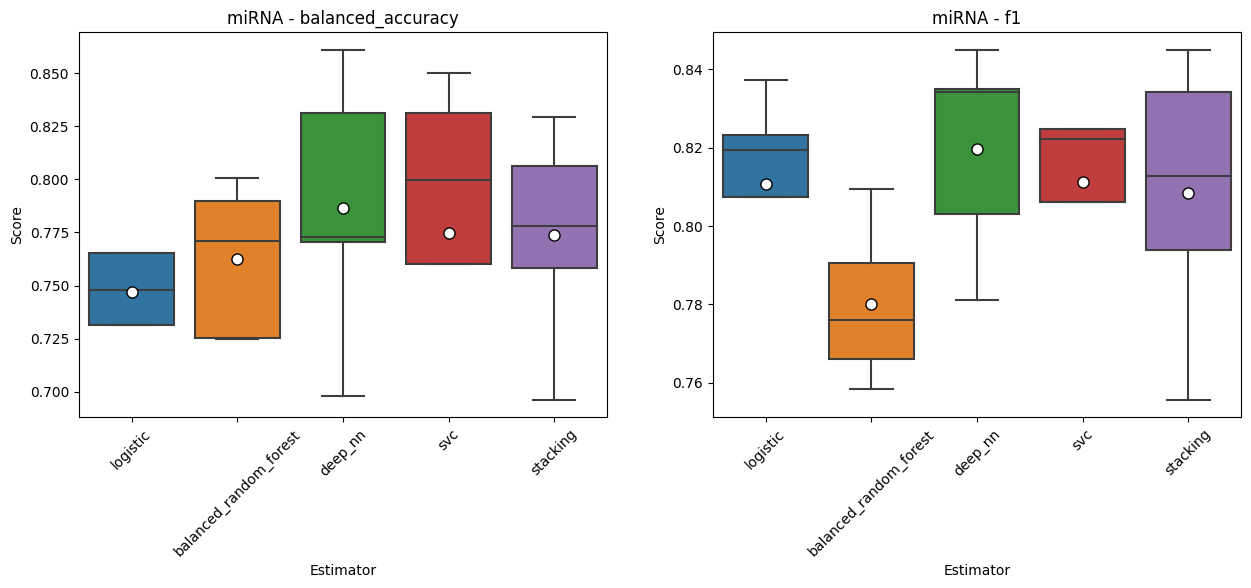

In [42]:
plot_box_scores(estimator_names, base_scores['mirna'], 'miRNA', metrics=['balanced_accuracy', 'f1'])

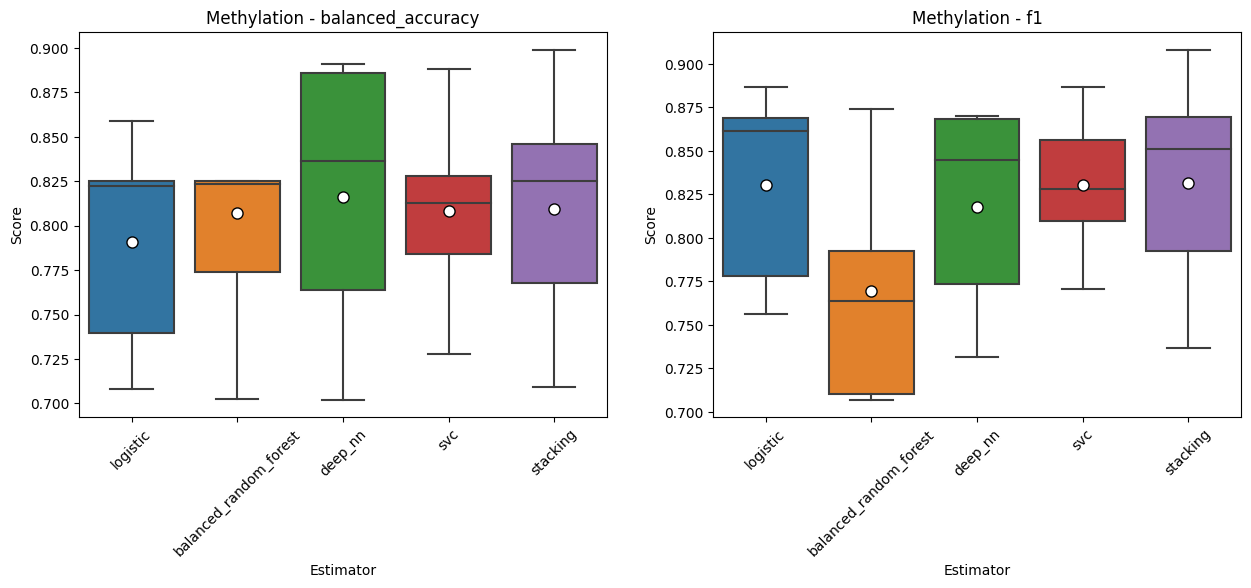

In [43]:
plot_box_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

# Multi Omics Integration Ensemble

In [44]:
preds = {}

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

for modality in tqdm(datasets):
    preds[modality] = cross_val_predict(classifiers[modality], X[modality], y, cv=skf, n_jobs=-1, method='predict_proba')

  0%|          | 0/3 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed

In [45]:
# Making dataframe of predicted class out of probabilities
preds_class_df = pd.DataFrame({
    'rna': preds['rna'].argmax(axis=1),
    'mirna': preds['mirna'].argmax(axis=1),
    'methylation': preds['methylation'].argmax(axis=1)
})

# Making dataframe of predicted probabilities
preds_proba_df = pd.concat([pd.DataFrame(preds['rna'], columns=['rna_basal', 'rna_her2', 'rna_lumA', 'rna_lumB']), pd.DataFrame(preds['mirna'], columns=['mirna_basal', 'mirna_her2', 'mirna_lumA', 'mirna_lumB']), pd.DataFrame(preds['methylation'], columns=['meth_basal', 'meth_her2', 'meth_lumA', 'meth_lumB'])], axis=1)

In [46]:
preds_class_df

,rna,mirna,methylation
0,2,2,2
1,2,2,3
2,3,3,3
3,2,2,3
4,2,2,2
...,...,...,...
425,2,2,2
426,2,2,2
427,0,0,0
428,2,2,2


In [47]:
preds_proba_df

,rna_basal,rna_her2,rna_lumA,rna_lumB,mirna_basal,mirna_her2,mirna_lumA,mirna_lumB,meth_basal,meth_her2,meth_lumA,meth_lumB
0,0.001467,0.004354,0.965726,0.028453,0.001078,0.008220,0.936370,0.054332,0.000671,0.004711,0.896438,0.098180
1,0.002184,0.024236,0.755083,0.218497,0.000598,0.023848,0.823479,0.152075,0.000549,0.052480,0.394258,0.552713
2,0.002522,0.031550,0.111947,0.853981,0.003155,0.049099,0.250103,0.697642,0.001715,0.028418,0.148201,0.821667
3,0.000938,0.007356,0.816674,0.175033,0.000420,0.013748,0.845570,0.140263,0.000212,0.031877,0.211672,0.756239
4,0.001671,0.001700,0.978412,0.018217,0.001401,0.008028,0.935068,0.055503,0.000896,0.003341,0.925915,0.069848
...,...,...,...,...,...,...,...,...,...,...,...,...
425,0.000837,0.006345,0.856288,0.136530,0.000324,0.009789,0.905747,0.084140,0.000194,0.008819,0.682378,0.308609
426,0.002038,0.003143,0.947915,0.046905,0.001352,0.009766,0.915568,0.073314,0.001103,0.004576,0.878705,0.115616
427,0.989094,0.009926,0.000354,0.000627,0.984652,0.006293,0.000068,0.008987,0.963867,0.032145,0.000170,0.003819
428,0.001407,0.002446,0.975383,0.020765,0.003914,0.003721,0.891747,0.100617,0.000802,0.003176,0.851003,0.145019


## With Voting

Hard Voting:

In [50]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, balanced_accuracy_score

def calculate_voting_scores(preds_class_df, y, name):
    # Find the majority class for each sample
    majority_class = preds_class_df.mode(axis=1)[0]

    # Calculate the scores
    accuracy = accuracy_score(y, majority_class)
    balanced_accuracy = balanced_accuracy_score(y, majority_class)
    f1 = f1_score(y, majority_class, average='weighted')
    recall = recall_score(y, majority_class, average=None)

    # Create a DataFrame with the scores
    scores_df = pd.DataFrame({
        'accuracy': [accuracy],
        'balanced_accuracy': [balanced_accuracy],
        'f1': [f1],
        'recall (Basal)': [recall[0]],
        'recall (Her2)': [recall[1]],
        'recall (LumA)': [recall[2]],
        'recall (LumB)': [recall[3]]
    })

    return scores_df.rename(index={0: name})

In [51]:
rna_mirna_meth = calculate_voting_scores(preds_class_df, y, 'rna_mirna_meth')
mirna_meth = calculate_voting_scores(preds_class_df[['mirna', 'methylation']], y, 'mirna_meth')
rna_meth = calculate_voting_scores(preds_class_df[['rna', 'methylation']], y, 'rna_meth')
rna_mirna = calculate_voting_scores(preds_class_df[['rna', 'mirna']], y, 'rna_mirna')

In [57]:
# Combine scores_df with modality_metrics
integration_voting_metrics = pd.concat([modality_metrics, rna_mirna_meth, mirna_meth, rna_meth, rna_mirna])
integration_voting_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
rna,0.907 +/- 0.030,0.886 +/- 0.053,0.905 +/- 0.032,0.972 +/- 0.034,0.833 +/- 0.183,0.947 +/- 0.023,0.790 +/- 0.111
mirna,0.816 +/- 0.027,0.774 +/- 0.046,0.808 +/- 0.032,0.958 +/- 0.057,0.667 +/- 0.211,0.900 +/- 0.059,0.570 +/- 0.150
methylation,0.835 +/- 0.055,0.809 +/- 0.065,0.832 +/- 0.060,0.958 +/- 0.034,0.733 +/- 0.082,0.886 +/- 0.038,0.660 +/- 0.169
rna_mirna_meth,0.881395,0.859599,0.878775,0.971831,0.833333,0.943231,0.69
mirna_meth,0.825581,0.783707,0.809114,0.971831,0.766667,0.956332,0.44
rna_meth,0.867442,0.831724,0.859753,0.971831,0.8,0.965066,0.59
rna_mirna,0.853488,0.829799,0.842497,0.971831,0.866667,0.960699,0.52


## With Stacking

In [58]:
integration_scores, integration_metrics = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_class_df, y, name='Integration Model', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.4s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


In [59]:
integration_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
Integration Model,0.881 +/- 0.023,0.806 +/- 0.033,0.876 +/- 0.025,0.972 +/- 0.034,0.533 +/- 0.125,0.947 +/- 0.023,0.770 +/- 0.108


In [73]:
rna_mirna_meth_scores, rna_mirna_meth_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df, y, name='rna + mirna + methylation', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})
mirna_meth_scores, mirna_meth_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['mirna_basal', 'mirna_her2', 'mirna_lumA', 'mirna_lumB', 'meth_basal', 'meth_her2', 'meth_lumA', 'meth_lumB']], y, name='mirna + methylation', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})
rna_meth_scores, rna_meth_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['rna_basal', 'rna_her2', 'rna_lumA', 'rna_lumB', 'meth_basal', 'meth_her2', 'meth_lumA', 'meth_lumB']], y, name='rna + methylation', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})
rna_mirna_scores, rna_mirna_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['rna_basal', 'rna_her2', 'rna_lumA', 'rna_lumB', 'mirna_basal', 'mirna_her2', 'mirna_lumA', 'mirna_lumB']], y, name='rna + mirna', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (Basal)': make_scorer(recall_multiclass, label=0), 'recall (Her2)': make_scorer(recall_multiclass, label=1), 'recall (LumA)': make_scorer(recall_multiclass, label=2), 'recall (LumB)': make_scorer(recall_multiclass, label=3)})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [74]:
integration_stacking_metrics = pd.concat([modality_metrics, rna_mirna_meth_df, mirna_meth_df, rna_meth_df, rna_mirna_df])

In [75]:
integration_stacking_metrics

,accuracy,balanced_accuracy,f1,recall (Basal),recall (Her2),recall (LumA),recall (LumB)
rna,0.907 +/- 0.030,0.886 +/- 0.053,0.905 +/- 0.032,0.972 +/- 0.034,0.833 +/- 0.183,0.947 +/- 0.023,0.790 +/- 0.111
mirna,0.816 +/- 0.027,0.774 +/- 0.046,0.808 +/- 0.032,0.958 +/- 0.057,0.667 +/- 0.211,0.900 +/- 0.059,0.570 +/- 0.150
methylation,0.835 +/- 0.055,0.809 +/- 0.065,0.832 +/- 0.060,0.958 +/- 0.034,0.733 +/- 0.082,0.886 +/- 0.038,0.660 +/- 0.169
rna + mirna + methylation,0.905 +/- 0.020,0.891 +/- 0.034,0.904 +/- 0.022,0.972 +/- 0.034,0.867 +/- 0.067,0.943 +/- 0.023,0.780 +/- 0.093
mirna + methylation,0.830 +/- 0.036,0.802 +/- 0.054,0.826 +/- 0.037,0.958 +/- 0.057,0.733 +/- 0.170,0.895 +/- 0.063,0.620 +/- 0.121
rna + methylation,0.909 +/- 0.017,0.888 +/- 0.031,0.908 +/- 0.019,0.972 +/- 0.034,0.833 +/- 0.149,0.948 +/- 0.018,0.800 +/- 0.105
rna + mirna,0.907 +/- 0.024,0.874 +/- 0.040,0.905 +/- 0.026,0.972 +/- 0.034,0.767 +/- 0.170,0.947 +/- 0.023,0.810 +/- 0.111


In [76]:
names = ['rna', 'mirna', 'methylation', 'rna + mirna + meth', 'mirna + meth', 'rna + meth', 'rna + mirna']
integration = []
integration.append(scores['rna'])
integration.append(scores['mirna'])
integration.append(scores['methylation'])
integration.append(rna_mirna_meth_scores)
integration.append(mirna_meth_scores)
integration.append(rna_meth_scores)
integration.append(rna_mirna_scores)

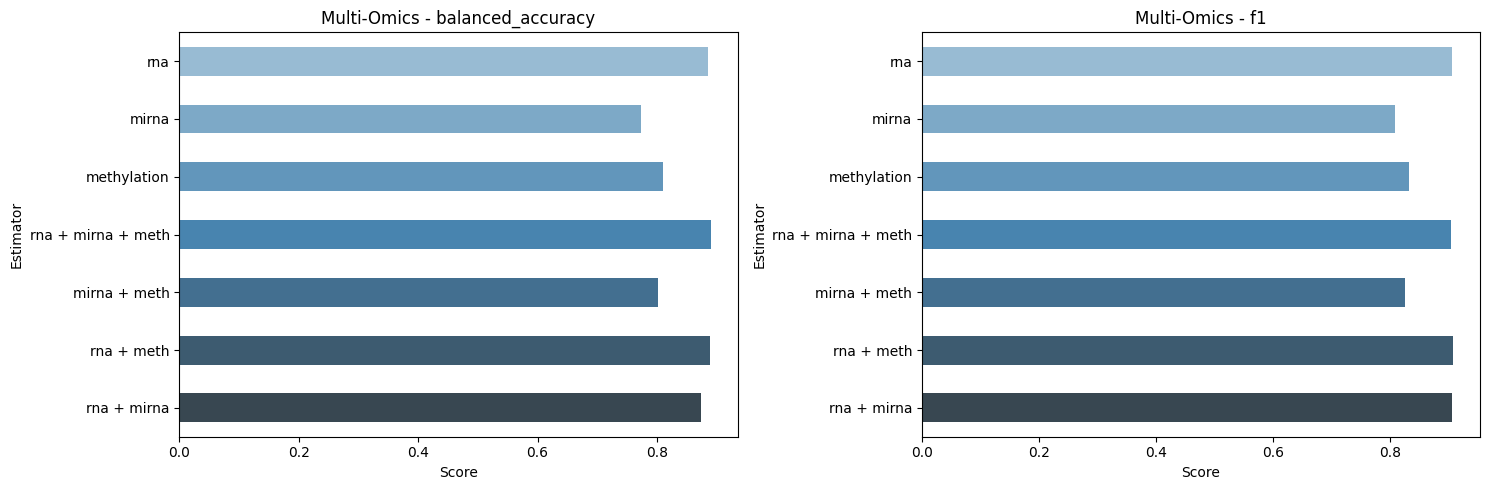

In [77]:
plot_bar_scores(names, integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

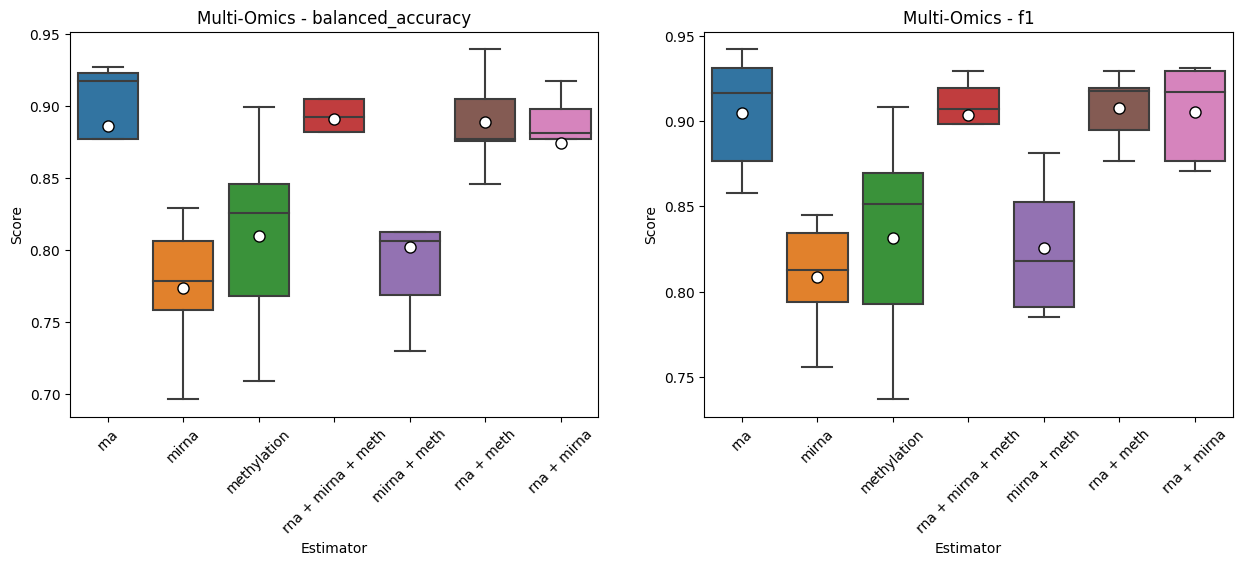

In [78]:
plot_box_scores(names, integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])